In [39]:
import numpy as np
import pandas as pd
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

## Clase Pipeline

En mi caso he seleccionado los modelos de scikit-learn necesarios para realizar un estandarizado de los datos, un PCA a modo de reducción de la dimensionalidad, y varios algoritmos de aprendizaje supervisado para clasificación.

He creado una clase con métodos para preprocesado de los datos, selección de modelos, entrenamiento, test y representaciones gráficas de resultados.

In [40]:
class Pipeline:
    
    def __init__(self):
        # Constructor por defecto:
        # En este caso sólo se crea el objeto Pipeline vacío, los parámetros y modelos se eligen
        # después (si no se quieren usar los de por defecto)
        pass
    
    
    
    def __preprocess(self, data, test_size=0.3, tarjet='median_house_value_discrete', random_state=42):
        # Método privado para prepocesar los datos.
        # En este caso no es general, es únicamente para el dataset que he seleccionado, aunque podría
        # hacerse más general.
        #
        # tarjet:      parámetro con el nombre de la variable objetivo.
        #
        # datos:       dataset con los datos. En este caso elimino outliers y discretizo la variable 'median_house_value'
        #              por 5 cuantiles (20% cada uno) como variable objetivo a clasificar.
        #
        # train, test: datasets de entrenamiento y test respectivamente. Podemos seleccionar el tamaño con 'test_size'
        #              y la semilla del generador aleatorio para que la partición sea siempre la misma.
        #
        # scaler:      el estandarizado de las variables, en este caso un 'StandardScaler' normal para centrar por la media y 
        #              dividir por la desviación estándar.
        
        self.tarjet = tarjet
        self.datos = data.loc[(data['median_house_value'] < 500000), :]
        self.datos[self.tarjet] = pd.qcut(self.datos['median_house_value'], 5, labels=[0, 1, 2, 3, 4])
        self.datos = self.datos.drop(columns='median_house_value')

        self.train, self.test = train_test_split(self.datos, test_size=test_size, random_state=random_state)
        self.scaler = StandardScaler()
        
    
    
    def __train_scaler(self):
        # Método privado para entrenar el Scaler.
        
        self.scaler.fit(self.train.drop(columns=self.tarjet))
    
    
    
    def scaler_transform(self, datos=pd.DataFrame(None)):
        # Método público para transformar los datos para escalarlos.
        # Si no le pasamos datos transforma los datos que hemos seleccionado para entrenamiento y 
        # los almacena en el parámetro 'scaled_predictors', sin embargo, si pasamos un dataset
        # nos transformará los datos que le pasemos y los devolverá.
        
        if not datos.empty:
            return self.scaler.transform(datos)
        else:
            self.scaled_predictors = self.scaler.transform(self.train.drop(columns=self.tarjet))
    
    
    
    def reduccion(self, model, **kwargs):
        # Método público para guardar en el parámetro 'red_model' el modelo que queramos usar para
        # reducción de la dimensionalidad. 
        # Podemos pasar también los argumentos necesarios para el algoritmo que hayamos seleccionado.
        
        self.red_model = model(**kwargs)
    
    
    
    def __train_reduccion(self):
        # Método privado para entrenar el algoritmo de reducción de la dimensionalidad con los datos escalados.
        
        self.red_model.fit(self.scaled_predictors)
    
    
    
    def reduccion_transform(self, datos=pd.DataFrame(None)):
        # Método público para transformar los datos con el algoritmo de reducción de la dimensionalidad.
        # Si no le pasamos datos transforma los datos que hemos seleccionado para entrenamiento y 
        # los almacena en el parámetro 'new_space', sin embargo, si pasamos un dataset
        # nos transformará los datos que le pasemos y los devolverá.
        
        if not datos.empty:
            return self.red_model.transform(datos)
        else:
            self.new_space = self.red_model.transform(self.scaled_predictors)
    
    
    
    def summary_reduccion(self):
        # Método público para presentar los resultados de la reducción de la dimensionalidad (en este caso PCA)
        
        plt.figure(figsize=(5, 5))

        plt.bar(range(1, 1 + self.red_model.explained_variance_ratio_.shape[0]), self.red_model.explained_variance_ratio_)
        plt.grid()
        plt.ylim((0, 1))
        plt.xlabel('Componentes')
        plt.ylabel('% varianza explicada')
        plt.title('Proporción de varianza explicada por componente')
        plt.show()
    
    
    
    def preparacion_datos(self, datos, **kwargs):
        # Método público para preparar los datos realizando todo el preprocesado.
        # Podemos pasar los distintos argumentos para modificar los valores por defecto.
        #
        # test_size:     tamaño del conjunto de test.
        #
        # tarjet:        nombre de la variable objetivo.
        #
        # random_state:  semilla para el generador de números aleatorios.
        #
        # model:         modelo de reducción de la dimensionalidad, por defecto PCA.
        #
        # n_components:  número de componentes principales para la PCA.
        #
        # Se actualizan todos los parámetros (si los pasamos para modificarlos) y se llama a todos
        # los métodos necesarios para dividir los datos en los conjuntos de entrenamiento y test,
        # entrenar el scaler, transformar los datos, entrenar el PCA y transformar los datos al nuevo
        # espacio obtenido con el PCA.
        
        test_size = 0.3
        tarjet = 'median_house_value_discrete'
        random_state = 42
        model = PCA
        n_components = 2
        for arg in kwargs.keys():
            if arg == 'test_size':
                test_size = kwargs[arg]
            if arg == 'tarjet':
                tarjet = kwargs[arg]
            if arg == 'random_state':
                random_state = kwargs[arg]
            if arg == 'model':
                model = kwargs[arg]
            if arg == 'n_components':
                n_components = kwargs[arg]
        self.__preprocess(datos, test_size=test_size, tarjet=tarjet, random_state=random_state)

        self.__train_scaler()

        self.scaler_transform()

        self.reduccion(model = model, n_components=n_components)

        self.__train_reduccion()

        self.reduccion_transform()
    
    
    
    def clasification(self, model, **kwargs):
        # Método público para guardar en el parámetro 'cl_model' el modelo que queramos usar para
        # la clasificación. 
        # Podemos pasar también los argumentos necesarios para el algoritmo que hayamos seleccionado.
        
        self.cl_model = model(**kwargs)
    
    
    
    def train_clasification(self):
        # Método público para entrenar el algoritmo de clasificación con los datos preprocesados.
        
        self.cl_model.fit(self.new_space, self.train.loc[:, self.tarjet])
    
    
    
    def predict(self, datos, prob=False):
        # Método público para realizar inferencia.
        # Con el parámetro 'prob' podemos controlar si nos devuelve las predicciones o probabilidades.
        
        if prob:
            return self.cl_model.predict_proba(datos)
        
        return self.cl_model.predict(datos)
    
    
    
    def __summary_results(self, X, y):
        # Método privado genérico para presentar resultados, en esta caso curva ROC con AUC.
        # Código copiado de la documentación de scikit-learn.
        
        y_test = pd.get_dummies(y).values
        y_score = self.predict(X, prob=True)
        n_classes = y_test.shape[1]
        lw = 2

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(5, 5))
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        colors = cycle(["aqua", "darkorange", "cornflowerblue", 'purple', 'lightgreen'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            )

        plt.plot([0, 1], [0, 1], "k--", lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic to multiclass")
        plt.legend(loc="lower right")
        plt.show()
    
    
    
    def summary_training(self):
        # Método público para presentar resultados en entrenamiento.
        
        self.__summary_results(self.new_space, self.train.loc[:, self.tarjet])
    
    
    
    def summary_test(self):
        # Método público para presentar resultados en test
        
        self.aux = pd.DataFrame(self.scaler_transform(self.test.drop(columns=self.tarjet)))
        self.aux = self.reduccion_transform(self.aux)

        self.__summary_results(self.aux, self.test.loc[:, self.tarjet])

## Carga de datos

In [41]:
df = pd.read_csv('housing.csv')
df = df.drop(columns=['ocean_proximity']).dropna()
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


In [42]:
df.loc[(df['median_house_value'] < 500000), :]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


## Instanciamos un objeto Pipeline

In [43]:
pipeline = Pipeline()
pipeline

In [44]:
pipeline.preparacion_datos(df, tarjet='y', n_components=5)

/tmp/ipykernel_30812/771037244.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.datos[self.tarjet] = pd.qcut(self.datos['median_house_value'], 5, labels=[0, 1, 2, 3, 4])


In [54]:
pd.DataFrame(pipeline.new_space)

,0,1,2,3,4
0,-0.875873,1.756316,-0.168376,0.209482,0.132394
1,-1.668570,2.494629,-0.747676,0.412365,-0.092252
2,-1.133939,1.668596,1.603565,1.191363,0.107149
3,-2.017467,1.511847,-1.373908,0.918390,0.050776
4,-0.008388,0.259736,-0.503733,0.281075,-0.340138
...,...,...,...,...,...
13608,-1.269237,-1.412357,0.097283,0.242200,0.012530
13609,-1.173629,1.435089,0.920479,-0.040795,0.064749
13610,-1.541726,-1.124798,0.926305,1.525439,-0.076564
13611,1.005215,1.533025,1.195647,-1.128807,-0.098025


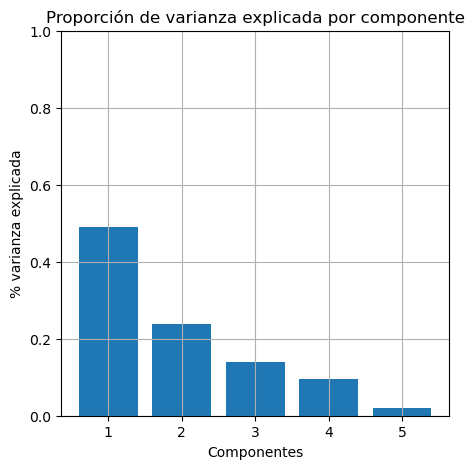

In [45]:
pipeline.summary_reduccion()

In [46]:
pipeline.clasification(DecisionTreeClassifier, criterion='entropy', min_samples_split=50, random_state=42)
pipeline.train_clasification()

In [47]:
# predicción datos train
pd.DataFrame(pipeline.predict(pipeline.new_space))

,0
0,0
1,0
2,4
3,1
4,0
...,...
13608,1
13609,3
13610,4
13611,2


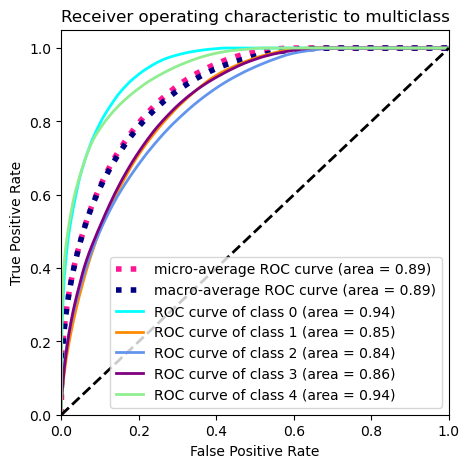

In [48]:
pipeline.summary_training()

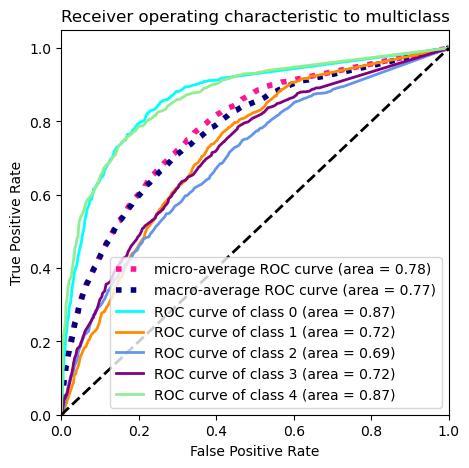

In [49]:
pipeline.summary_test()

In [50]:
# predicción datos test
pd.DataFrame(pipeline.predict(pipeline.aux))

,0
0,1
1,1
2,0
3,4
4,0
...,...
5830,2
5831,0
5832,2
5833,1


 ## Repetimos lo mismo cambiando el algoritmo de clasificación

In [51]:
pipeline.clasification(RandomForestClassifier, criterion='entropy', min_samples_split=50, random_state=42, n_estimators=1000)
pipeline.train_clasification()

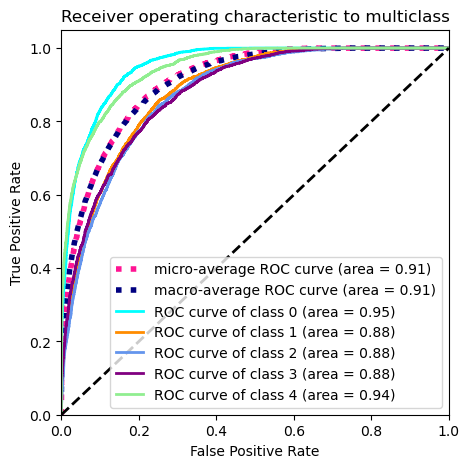

In [52]:
pipeline.summary_training()

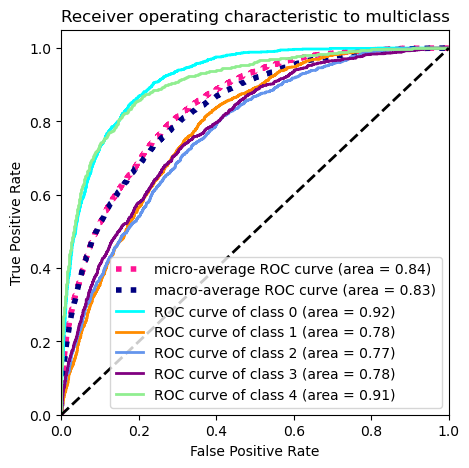

In [53]:
pipeline.summary_test()